In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
from performance import performance
from datetime import timedelta
import time
import matplotlib
import matplotlib.font_manager as fm
# fm.get_fontconfig_fonts()
# font_location = '/usr/share/fonts/truetype/nanum/NanumGothicOTF.ttf'
font_location = 'C:/Windows/Fonts/gulim.ttc' # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

# 로그정규분포

## 보통심박

In [2]:
df = pd.read_csv('../data/로그정규/보통심박.csv', encoding='cp949')
df.head()

,time,heart_rate1,event1,heart_rate2,event2,heart_rate3,event3,heart_rate4,event4,heart_rate5,...,heart_rate96,event96,heart_rate97,event97,heart_rate98,event98,heart_rate99,event99,heart_rate100,event100
0,2024-01-01 09:00:00,85.689072,0,83.619243,0,100.388465,1,68.436331,0,89.053103,...,79.909588,0,78.703384,0,74.131167,0,85.103926,0,104.703351,1
1,2024-01-01 09:01:00,70.799472,0,80.284777,0,79.134970,0,86.997365,0,89.120294,...,81.876244,0,70.098775,0,77.329517,0,80.226264,0,60.309250,0
2,2024-01-01 09:02:00,90.464723,0,81.731639,0,71.164349,0,70.838389,0,73.196052,...,68.041412,0,78.158418,0,109.488324,1,92.867687,0,77.533786,0
3,2024-01-01 09:03:00,94.861898,0,69.308866,0,91.127339,0,91.104647,0,96.072022,...,77.655031,0,69.521634,0,79.830681,0,79.874469,0,78.030680,0
4,2024-01-01 09:04:00,63.234515,0,65.050540,0,69.106824,0,75.792911,0,85.762406,...,79.672938,0,88.693922,0,67.033962,0,76.499590,0,78.631584,0


In [3]:
# 분석
df_copy = df.copy()

# 데이터를 df_train과 df_test로 분할
df_train = df_copy[:16380]
df_test = df_copy[16380:]

print(df_train.shape)
print(df_test.shape)

(16380, 201)
(7800, 201)


In [45]:
# 1. ewma 함수 사용 근데 event변수가 없이 나옴
def ewma_outlier_detection(data, initial, gamma, k):
    ewma_results = pd.DataFrame()  # 각 heart_rate 변수에 대한 결과를 저장할 데이터프레임

    for i in range(1, 101):
        ewma = pd.DataFrame(data[f'heart_rate{i}'])  # 복사본을 생성
        ewma['EWMA'] = initial
        for index, row in ewma.iterrows():
            if index > 0:
                ewma.loc[index, 'EWMA'] = gamma * ewma.loc[index, f'heart_rate{i}'] + (1 - gamma) * ewma.loc[index - 1, 'EWMA']

        # Calculate STD
        std = ewma[f'heart_rate{i}'].std()

        # Calculate control limits
        ewma['LCL'] = ewma['EWMA'] - k * np.sqrt(gamma / (2 - gamma)) * std
        ewma['UCL'] = ewma['EWMA'] + k * np.sqrt(gamma / (2 - gamma)) * std

        # Tag outliers
        ewma[f'pred_y{i}'] = np.where((ewma[f'heart_rate{i}'] < ewma['LCL']) | (ewma[f'heart_rate{i}'] > ewma['UCL']), 1, 0)

        # 결과 데이터프레임에 추가
        ewma_results = pd.concat([ewma_results, ewma[[f'heart_rate{i}', f'pred_y{i}', 'LCL', 'UCL']]], axis=1)

    return ewma_results

In [42]:
# 2. 신뢰구간 없이 원래 출력되는대로
def ewma2(data, initial, gamma, k):
    # 결과를 저장할 새 데이터프레임을 생성합니다.
    ewma_results = pd.DataFrame()

    # 각 heart_rate 변수에 대해 EWMA 및 이상치 탐지를 수행합니다.
    for i in range(1, 101):
        # 각 heart_rate 열에 대해 EWMA를 계산합니다.
        ewma = initial
        lcl = ucl = std = 0
        pred_y = []
        for value in data[f'heart_rate{i}']:
            ewma = gamma * value + (1 - gamma) * ewma
            std = np.sqrt(((std**2) * (1 - gamma)) + (gamma * (value - ewma)**2))
            lcl = ewma - k * np.sqrt(gamma / (2 - gamma)) * std
            ucl = ewma + k * np.sqrt(gamma / (2 - gamma)) * std
            pred_y.append(1 if (value < lcl) or (value > ucl) else 0)
        
        # 이상치 탐지 결과를 데이터프레임에 추가합니다.
        ewma_results[f'heart_rate{i}'] = data[f'heart_rate{i}']
        ewma_results[f'event{i}'] = data[f'event{i}']
        ewma_results[f'pred_y{i}'] = pred_y

    # 결과 데이터프레임을 반환합니다.
    return ewma_results

In [59]:
for i in range(1, 101):
    # EWMA 계산
    df_copy[f'ewma_{i}'] = df_copy[f'heart_rate{i}'].ewm(span=12).mean()
    
    # EWMA의 표준편차 계산
    df_copy[f'ewma_std_{i}'] = df_copy[f'heart_rate{i}'].ewm(span=12).std()
    
    # 95% 신뢰구간 계산
    df_copy[f'lower_{i}'] = df_copy[f'ewma_{i}'] - 2 * df_copy[f'ewma_std_{i}']
    df_copy[f'upper_{i}'] = df_copy[f'ewma_{i}'] + 2 * df_copy[f'ewma_std_{i}']
    
    # 실제 값이 신뢰구간을 벗어나는 경우 이상치로 판단
    df_copy[f'pred_y{i}'] = np.where((df_copy[f'heart_rate{i}'] < df_copy[f'lower_{i}']) | (df_copy[f'heart_rate{i}'] > df_copy[f'upper_{i}']), 1, 0)
    
    # 필요 없는 열 삭제
    df_copy.drop(columns=[f'ewma_{i}', f'ewma_std_{i}', f'lower_{i}', f'upper_{i}'], inplace=True)

In [46]:
# 함수 적용
start_time = time.time()

outdata_95_3 = ewma_outlier_detection(df, 80, 0.95, 3)
outdata_95_5 = ewma_outlier_detection(df, 80, 0.95, 5)
outdata_90_3 = ewma_outlier_detection(df, 80, 0.9, 3)
outdata_90_5 = ewma_outlier_detection(df, 80, 0.9, 5)
outdata_50_3 = ewma_outlier_detection(df, 80, 0.5, 3)
outdata_50_5 = ewma_outlier_detection(df, 80, 0.5, 5)
outdata_30_3 = ewma_outlier_detection(df, 80, 0.3, 3)
outdata_30_5 = ewma_outlier_detection(df, 80, 0.3, 5)

end_time = time.time()
time_diff = end_time - start_time
time_diff = str(timedelta(seconds=time_diff))
print('코드 실행 시간: {}'.format(time_diff))

코드 실행 시간: 0:48:22.929231


In [4]:
import numpy as np
from sklearn.metrics import confusion_matrix

start_time = time.time()
# 최적의 매개변수를 찾기 위한 그리드 서치 함수
def grid_search_ewma(df_copy, span_values, beta):
    best_span = None
    best_f_score = -np.inf  # F-beta score가 최대가 되는 것을 찾음
    best_performance = pd.DataFrame()
    
    # 16380번째 행부터 시작하는 부분집합으로 df_copy 업데이트
    df_test = df_copy.iloc[16380:].copy()  # 인덱스는 0부터 시작하므로 16379를 사용
    
    for span in span_values:
        f_scores = []
        performance_results = pd.DataFrame()
        
        for i in range(1, 101):
            # EWMA 계산
            ewma = df_test[f'heart_rate{i}'].ewm(span=span).mean()
            std = df_test[f'heart_rate{i}'].ewm(span=span).std()
            # 신뢰 구간 계산
            lower = ewma - 2 * std
            upper = ewma + 2 * std
            # 예측 값 계산 및 df_test에 추가
            df_test[f'pred_y{i}'] = np.where((df_test[f'heart_rate{i}'] < lower) | (df_test[f'heart_rate{i}'] > upper), 1, 0)
            
            # 실제와 예측 값으로부터 혼동 행렬(confusion matrix) 계산
            actual_y = df_test[f'event{i}']
            pred_y = df_test[f'pred_y{i}']
            TP, FN, FP, TN = confusion_matrix(actual_y, pred_y, labels=[1, 0]).ravel()
    
            
            # 성능 지표 계산
            result_i = performance(TP=TP, TN=TN, FP=FP, FN=FN, BETA=beta)
            
            # 각 성능 지표 저장
            performance_results = pd.concat([performance_results, result_i])
            
            # F-beta 점수 추출
            f_score = result_i.loc[0, f'F_{beta} score']
            f_scores.append(f_score)
        
        # 평균 F-beta 점수 계산
        avg_f_score = np.mean(f_scores)
        
        # 최고 성능 업데이트
        if avg_f_score > best_f_score:
            best_f_score = avg_f_score
            best_span = span
            best_performance = performance_results
        
    return best_span, best_performance, df_test

# 예제 사용
span_values = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]  # 탐색할 스팬 값들
best_span, best_performance, df_test = grid_search_ewma(df_copy, span_values, beta=1)
print(f"Best span: {best_span}")
print(best_performance.mean())  # 각 성능 지표의 평균 값을 출력
print(best_performance.std())

end_time = time.time()
time_diff = end_time - start_time
time_diff = str(timedelta(seconds=time_diff))
print('코드 실행 시간: {}'.format(time_diff))

Best span: 20
Sensitivity    26.233313
Specificity    99.898762
Accuracy       96.382692
Precision      92.814575
NPV            96.431184
F_1 score      40.849972
dtype: float64
Sensitivity    2.507927
Specificity    0.041391
Accuracy       0.264596
Precision      2.959369
NPV            0.260492
F_1 score      3.181548
dtype: float64
코드 실행 시간: 0:00:19.547758


In [5]:
print(df_test[df_test['pred_y1'] == 1].shape)

(101, 301)


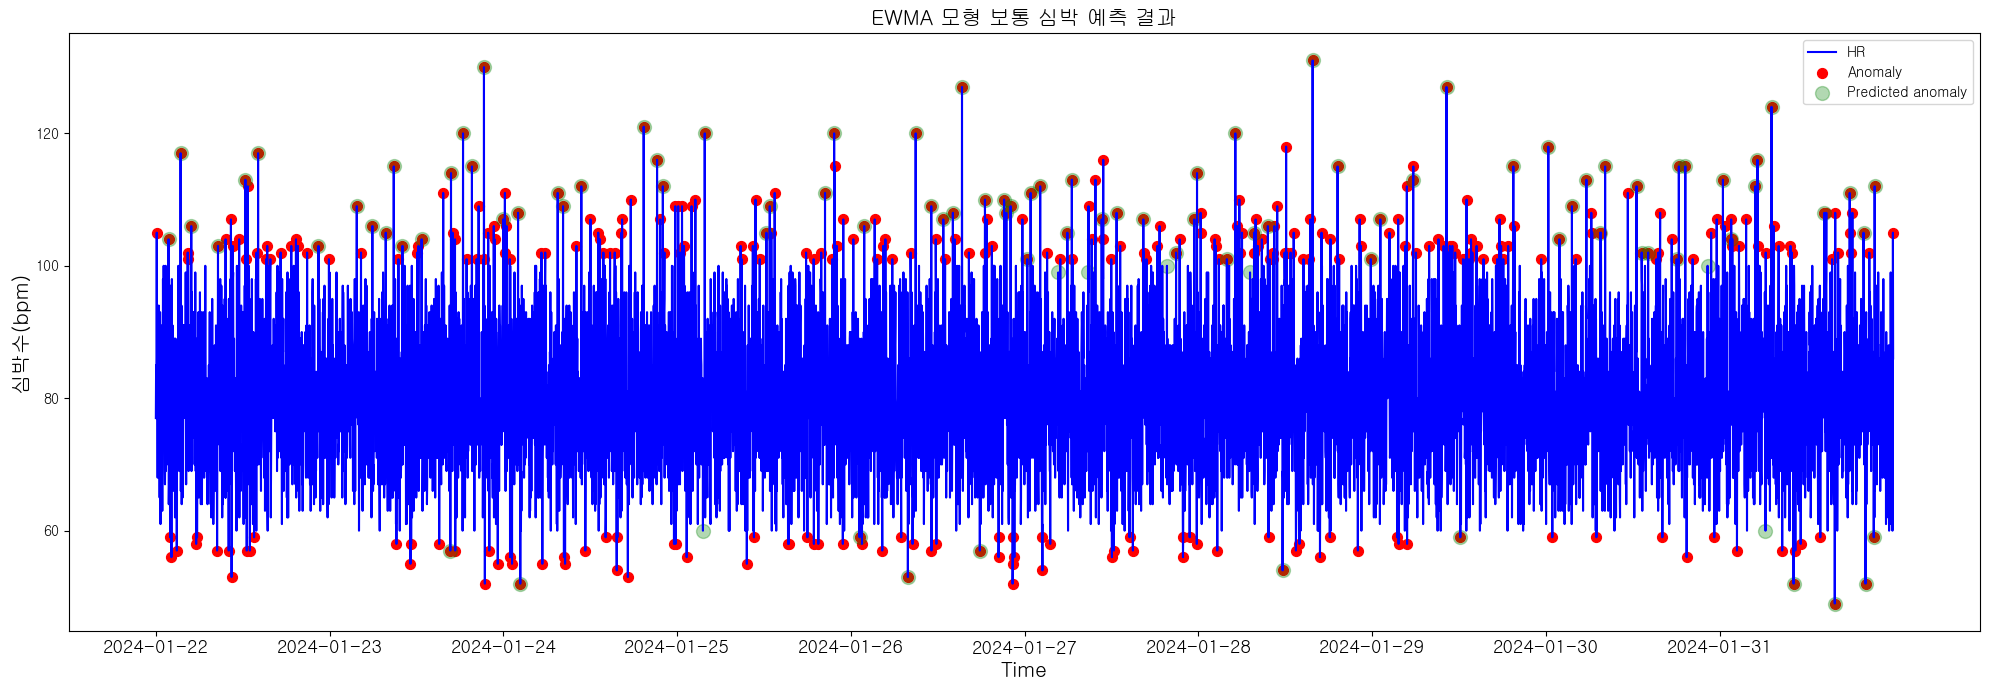

In [119]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# ... df_test를 불러오고 필요한 데이터 처리를 하는 코드 ...

# 가정: 'time' 열이 이미 datetime 타입으로 변환되었음
# 예: df_test['time'] = pd.to_datetime(df_test['time'])
df_test['time'] = pd.to_datetime(df_test['time'])

# 데이터의 시작과 끝 날짜를 기준으로 날짜 범위를 생성
date_range = pd.date_range(start=df_test['time'].iloc[0], end=df_test['time'].iloc[-1], freq='D')

# 날짜 범위에 대한 인덱스를 찾음
# 이 때, 각 날짜에 대응하는 데이터가 실제로 존재하는지 확인함
date_ticks = [df_test[df_test['time'].dt.date == date.date()].index[0] for date in date_range if not df_test[df_test['time'].dt.date == date.date()].empty]

plt.figure(figsize=(20,7))
plt.plot(df_test['heart_rate1'], label='HR', color='blue')  # 'time' 열을 제외하고 인덱스에 따라 플롯

# 실제 이상치 시각화
plt.scatter(df_test[df_test['event1'] == 1].index, 
            df_test[df_test['event1'] == 1]['heart_rate1'],
            color='red', label='Anomaly', s=50)

# 예측된 이상치 시각화
plt.scatter(df_test[df_test['pred_y1'] == 1].index, 
            df_test[df_test['pred_y1'] == 1]['heart_rate1'],
            color='green', label='Predicted anomaly', s=100, alpha=0.3)

# x축 눈금과 레이블 설정
plt.xticks(ticks=date_ticks, labels=[date.strftime('%Y-%m-%d') for date in date_range if not df_test[df_test['time'].dt.date == date.date()].empty], fontsize=13)

plt.xlabel('Time', fontsize=15, fontweight='bold')
plt.ylabel('심박수(bpm)', fontsize=15, fontweight='bold')
plt.title('EWMA 모형 보통 심박 예측 결과', fontsize=15, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()

In [43]:
# 함수 적용
start_time = time.time()

result_95_3 = ewma2(df, 80, 0.95, 3)
result_95_5 = ewma2(df, 80, 0.95, 5)
result_90_3 = ewma2(df, 80, 0.9, 3)
result_90_5 = ewma2(df, 80, 0.9, 5)
result_50_3 = ewma2(df, 80, 0.5, 3)
result_50_5 = ewma2(df, 80, 0.5, 5)
result_30_3 = ewma2(df, 80, 0.3, 3)
result_30_5 = ewma2(df, 80, 0.3, 5)

end_time = time.time()
time_diff = end_time - start_time
time_diff = str(timedelta(seconds=time_diff))
print('코드 실행 시간: {}'.format(time_diff))

코드 실행 시간: 0:02:10.582223


In [64]:
result_10 = ewma2(df, 80, 0.95, 10)
result_12 = ewma2(df, 80, 0.95, 12)

In [65]:
result10 = result_10[16380:].copy()
result12 = result_12[16380:].copy()

In [68]:
result_5 = pd.DataFrame()

for i in range(1,101):

    TP = len(result12[(result12[f'event{i}']==1)&(result12[f'pred_y{i}']==1)])
    TN = len(result12[(result12[f'event{i}']==0)&(result12[f'pred_y{i}']==0)])
    FN = len(result12[(result12[f'event{i}']==1)&(result12[f'pred_y{i}']==0)])
    FP = len(result12[(result12[f'event{i}']==0)&(result12[f'pred_y{i}']==1)])

    result_i = performance(TP=TP, TN=TN, FP=FP, FN=FN, BETA=1)
    
    result_5 = pd.concat([result_5, result_i])


result_5.tail(3)

,Sensitivity,Specificity,Accuracy,Precision,NPV,F_1 score
0,0.0,100.0,94.589744,0,94.589744,0
0,0.0,100.0,94.705128,0,94.705128,0
0,0.0,100.0,95.089744,0,95.089744,0


In [67]:
result_4 = pd.DataFrame()

for i in range(1,101):

    TP = len(result10[(result10[f'event{i}']==1)&(result10[f'pred_y{i}']==1)])
    TN = len(result10[(result10[f'event{i}']==0)&(result10[f'pred_y{i}']==0)])
    FN = len(result10[(result10[f'event{i}']==1)&(result10[f'pred_y{i}']==0)])
    FP = len(result10[(result10[f'event{i}']==0)&(result10[f'pred_y{i}']==1)])

    result_i = performance(TP=TP, TN=TN, FP=FP, FN=FN, BETA=1)
    
    result_4 = pd.concat([result_4, result_i])


result_4.tail(3)

,Sensitivity,Specificity,Accuracy,Precision,NPV,F_1 score
0,0.0,100.0,94.589744,0,94.589744,0
0,0.0,100.0,94.705128,0,94.705128,0
0,0.0,100.0,95.089744,0,95.089744,0


## 2. 2030대

In [71]:
df2030 = pd.read_csv('../data/로그정규/심박_2030.csv', encoding='cp949')

print(df.shape)
df2030.head(2)

(24180, 201)


,time,heart_rate1,heart_rate2,heart_rate3,heart_rate4,heart_rate5,heart_rate6,heart_rate7,heart_rate8,heart_rate9,...,event91,event92,event93,event94,event95,event96,event97,event98,event99,event100
0,2024-01-01 09:00:00,89.954523,104.635743,90.011734,109.262882,110.612551,94.994347,88.828494,106.176256,104.414570,...,0,0,0,0,0,0,0,0,0,0
1,2024-01-01 09:01:00,78.053178,95.043544,115.960850,117.598221,113.346876,107.483873,113.218967,94.632922,103.084988,...,0,0,0,0,0,0,0,0,0,0


In [82]:
copy_2030 = df2030.copy()

start_time = time.time()
# 최적의 매개변수를 찾기 위한 그리드 서치 함수
def grid_search_ewma(copy_2030, span_values, beta):
    best_span = None
    best_f_score = -np.inf  # F-beta score가 최대가 되는 것을 찾음
    best_performance = pd.DataFrame()
    
    # 16380번째 행부터 시작하는 부분집합으로 copy_2030 업데이트
    df_test = copy_2030.iloc[16380:].copy()  # 인덱스는 0부터 시작하므로 16379를 사용
    
    for span in span_values:
        f_scores = []
        performance_results = pd.DataFrame()
        
        for i in range(1, 101):
            # EWMA 계산
            ewma = df_test[f'heart_rate{i}'].ewm(span=span).mean()
            std = df_test[f'heart_rate{i}'].ewm(span=span).std()
            # 신뢰 구간 계산
            lower = ewma - 2 * std
            upper = ewma + 2 * std
            # 예측 값 계산
            pred_y = np.where((df_test[f'heart_rate{i}'] < lower) | (df_test[f'heart_rate{i}'] > upper), 1, 0)
            
            # 실제와 예측 값으로부터 혼동 행렬(confusion matrix) 계산
            actual_y = df_test[f'event{i}']
            TP, FN, FP, TN = confusion_matrix(actual_y, pred_y, labels=[1, 0]).ravel()
            
            # 성능 지표 계산
            result_i = performance(TP=TP, TN=TN, FP=FP, FN=FN, BETA=beta)
            
            # 각 성능 지표 저장
            performance_results = pd.concat([performance_results, result_i])
            
            # F-beta 점수 추출
            f_score = result_i.loc[0, f'F_{beta} score']
            f_scores.append(f_score)
        
        # 평균 F-beta 점수 계산
        avg_f_score = np.mean(f_scores)
        
        # 최고 성능 업데이트
        if avg_f_score > best_f_score:
            best_f_score = avg_f_score
            best_span = span
            best_performance = performance_results
        
    return best_span, best_performance

# 예제 사용
span_values = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]  # 탐색할 스팬 값들
best_span, best_performance = grid_search_ewma(copy_2030, span_values, beta=1)
print(f"Best span: {best_span}")
print(best_performance.mean())
print(best_performance.std())  # 각 성능 지표의 평균 값을 출력

end_time = time.time()
time_diff = end_time - start_time
time_diff = str(timedelta(seconds=time_diff))
print('코드 실행 시간: {}'.format(time_diff))

Best span: 20
Sensitivity    71.669788
Specificity    99.752088
Accuracy       98.268462
Precision      94.145965
NPV            98.440778
F_1 score      81.358662
dtype: float64
Sensitivity    2.295962
Specificity    0.056869
Accuracy       0.166121
Precision      1.325290
NPV            0.174858
F_1 score      1.511417
dtype: float64
코드 실행 시간: 0:00:13.666023


## 3. 4050대

In [77]:
df4050 = pd.read_csv('../data/로그정규/심박_4050.csv', encoding='cp949')

print(df4050.shape)
print(df.shape)
df4050.head(2)

(24180, 201)
(24180, 201)


,time,heart_rate1,heart_rate2,heart_rate3,heart_rate4,heart_rate5,heart_rate6,heart_rate7,heart_rate8,heart_rate9,...,event91,event92,event93,event94,event95,event96,event97,event98,event99,event100
0,2024-01-01 09:00:00,97.496679,95.672346,100.678662,53.000000,105.679373,130.682394,88.561378,95.356306,106.860179,...,0,0,0,0,0,0,0,0,0,0
1,2024-01-01 09:01:00,123.889031,104.990027,95.802568,112.202551,108.467463,100.182643,107.510929,109.943174,106.137830,...,0,0,0,0,0,0,0,0,0,0


In [81]:
copy_4050 = df4050.copy()

start_time = time.time()
# 최적의 매개변수를 찾기 위한 그리드 서치 함수
def grid_search_ewma(copy_4050, span_values, beta):
    best_span = None
    best_f_score = -np.inf  # F-beta score가 최대가 되는 것을 찾음
    best_performance = pd.DataFrame()
    
    # 16380번째 행부터 시작하는 부분집합으로 copy_4050 업데이트
    df_test4050 = copy_4050.iloc[16380:].copy()  # 인덱스는 0부터 시작하므로 16379를 사용
    
    for span in span_values:
        f_scores = []
        performance_results = pd.DataFrame()
        
        for i in range(1, 101):
            # EWMA 계산
            ewma = df_test4050[f'heart_rate{i}'].ewm(span=span).mean()
            std = df_test4050[f'heart_rate{i}'].ewm(span=span).std()
            # 신뢰 구간 계산
            lower = ewma - 2 * std
            upper = ewma + 2 * std
            # 예측 값 계산
            pred_y = np.where((df_test4050[f'heart_rate{i}'] < lower) | (df_test4050[f'heart_rate{i}'] > upper), 1, 0)
            
            # 실제와 예측 값으로부터 혼동 행렬(confusion matrix) 계산
            actual_y = df_test4050[f'event{i}']
            TP, FN, FP, TN = confusion_matrix(actual_y, pred_y, labels=[1, 0]).ravel()
            
            # 성능 지표 계산
            result_i = performance(TP=TP, TN=TN, FP=FP, FN=FN, BETA=beta)
            
            # 각 성능 지표 저장
            performance_results = pd.concat([performance_results, result_i])
            
            # F-beta 점수 추출
            f_score = result_i.loc[0, f'F_{beta} score']
            f_scores.append(f_score)
        
        # 평균 F-beta 점수 계산
        avg_f_score = np.mean(f_scores)
        
        # 최고 성능 업데이트
        if avg_f_score > best_f_score:
            best_f_score = avg_f_score
            best_span = span
            best_performance = performance_results
        
    return best_span, best_performance

# 예제 사용
span_values = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]  # 탐색할 스팬 값들
best_span, best_performance = grid_search_ewma(copy_4050, span_values, beta=1)
print(f"Best span: {best_span}")
print(best_performance.mean())
print(best_performance.std())  # 각 성능 지표의 평균 값을 출력

end_time = time.time()
time_diff = end_time - start_time
time_diff = str(timedelta(seconds=time_diff))
print('코드 실행 시간: {}'.format(time_diff))

Best span: 20
Sensitivity    73.118447
Specificity    99.673579
Accuracy       98.342051
Precision      92.178361
NPV            98.596497
F_1 score      81.524643
dtype: float64
Sensitivity    2.391722
Specificity    0.067321
Accuracy       0.154609
Precision      1.652245
NPV            0.153601
F_1 score      1.694163
dtype: float64
코드 실행 시간: 0:00:13.457914


## 4. 6070대

In [79]:
df6070 = pd.read_csv('../data/로그정규/심박_6070.csv', encoding='cp949')

print(df.shape)
print(df6070.shape)
df6070.head(2)

(24180, 201)
(24180, 201)


,time,heart_rate1,heart_rate2,heart_rate3,heart_rate4,heart_rate5,heart_rate6,heart_rate7,heart_rate8,heart_rate9,...,event91,event92,event93,event94,event95,event96,event97,event98,event99,event100
0,2024-01-01 09:00:00,100.552583,90.631228,90.304552,99.148547,96.394693,100.578453,94.944473,104.926710,96.883610,...,0,0,0,0,0,1,0,0,0,0
1,2024-01-01 09:01:00,102.697944,101.353462,90.015000,93.630333,104.175350,96.465290,107.683246,96.756633,97.558345,...,0,0,0,0,0,0,0,0,0,0


In [83]:
copy_6070 = df6070.copy()

start_time = time.time()
# 최적의 매개변수를 찾기 위한 그리드 서치 함수
def grid_search_ewma(copy_6070, span_values, beta):
    best_span = None
    best_f_score = -np.inf  # F-beta score가 최대가 되는 것을 찾음
    best_performance = pd.DataFrame()
    
    # 16380번째 행부터 시작하는 부분집합으로 copy_6070 업데이트
    df_test6070 = copy_6070.iloc[16380:].copy()  # 인덱스는 0부터 시작하므로 16379를 사용
    
    for span in span_values:
        f_scores = []
        performance_results = pd.DataFrame()
        
        for i in range(1, 101):
            # EWMA 계산
            ewma = df_test6070[f'heart_rate{i}'].ewm(span=span).mean()
            std = df_test6070[f'heart_rate{i}'].ewm(span=span).std()
            # 신뢰 구간 계산
            lower = ewma - 2 * std
            upper = ewma + 2 * std
            # 예측 값 계산
            pred_y = np.where((df_test6070[f'heart_rate{i}'] < lower) | (df_test6070[f'heart_rate{i}'] > upper), 1, 0)
            
            # 실제와 예측 값으로부터 혼동 행렬(confusion matrix) 계산
            actual_y = df_test6070[f'event{i}']
            TP, FN, FP, TN = confusion_matrix(actual_y, pred_y, labels=[1, 0]).ravel()
            
            # 성능 지표 계산
            result_i = performance(TP=TP, TN=TN, FP=FP, FN=FN, BETA=beta)
            
            # 각 성능 지표 저장
            performance_results = pd.concat([performance_results, result_i])
            
            # F-beta 점수 추출
            f_score = result_i.loc[0, f'F_{beta} score']
            f_scores.append(f_score)
        
        # 평균 F-beta 점수 계산
        avg_f_score = np.mean(f_scores)
        
        # 최고 성능 업데이트
        if avg_f_score > best_f_score:
            best_f_score = avg_f_score
            best_span = span
            best_performance = performance_results
        
    return best_span, best_performance

# 예제 사용
span_values = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]  # 탐색할 스팬 값들
best_span, best_performance = grid_search_ewma(copy_6070, span_values, beta=1)
print(f"Best span: {best_span}")
print(best_performance.mean())  # 각 성능 지표의 평균 값을 출력
print(best_performance.std())

end_time = time.time()
time_diff = end_time - start_time
time_diff = str(timedelta(seconds=time_diff))
print('코드 실행 시간: {}'.format(time_diff))

Best span: 20
Sensitivity    78.492081
Specificity    99.664184
Accuracy       98.638846
Precision      92.222061
NPV            98.913782
F_1 score      84.786023
dtype: float64
Sensitivity    2.242581
Specificity    0.068312
Accuracy       0.144187
Precision      1.615188
NPV            0.131399
F_1 score      1.608271
dtype: float64
코드 실행 시간: 0:00:13.530758
